In [48]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from time import time
from models import ADTOF_FrameRNN, ADTOF_FrameAttention
from preprocess import compute_normalization, create_transform
from evaluate import compute_peaks, compute_predictions, f_measure, evaluate_model
from pathlib import Path

import matplotlib.pyplot as plt

## Load a model

In [38]:
# Create a path to the study directory
path = Path("study/Architectural Performance/Test Test/ADTOF-YT").resolve()

# Load the training config
config = torch.load(path / "config.pt")

# And the model
model = ADTOF_FrameAttention(**config["parameters"])
state_dict = torch.load(path / "model.pt", map_location="cpu")
model.load_state_dict(state_dict)

<All keys matched successfully>

## Visualize model prediction on a datapoint

In [79]:
def plot_prediction(model: nn.Module, data: torch.Tensor, label: torch.Tensor) -> None:

    # Predict using the model
    with torch.no_grad():
        activation = F.sigmoid(model(data.permute(0, 3, 1, 2)))
        prediction = compute_peaks(activation).round()

    # And plot
    fig, ax = plt.subplots(3)

    ax[0].set_title("Data (400 frames, 84 bins, 1 channel)")
    ax[0].imshow(data.squeeze().T)
    ax[0].set_xlabel("Frames (hop size: 10ms)")
    ax[0].set_ylabel("Frequency bins")

    ax[1].set_title("Target (400 frames, 5 classes)")
    ax[1].imshow(label.squeeze().flip(dims=[-1]).T, aspect=10, interpolation="nearest")
    ax[1].set_xlabel("Frames (hop size: 10ms)")
    ax[1].set_ylabel("Classes")
    ax[1].set_yticks([0, 1, 2, 3, 4], ("CY+RD", "HH", "TT", "SD", "BD"))

    ax[2].set_title("Prediction (400 frames, 5 classes)")
    ax[2].imshow(prediction.squeeze().flip(dims=[-1]).T, aspect=10, interpolation="nearest")
    ax[2].set_xlabel("Frames (hop size: 10ms)")
    ax[2].set_ylabel("Classes")
    ax[2].set_yticks([0, 1, 2, 3, 4], ("CY+RD", "HH", "TT", "SD", "BD"))

    fig.tight_layout()
    plt.show()

In [81]:
# Load the validation dataset
val_path = Path("data/adtof/adtof_yt_validation.pt").resolve()
val_loader = DataLoader(torch.load(val_path), shuffle=True, batch_size=1)

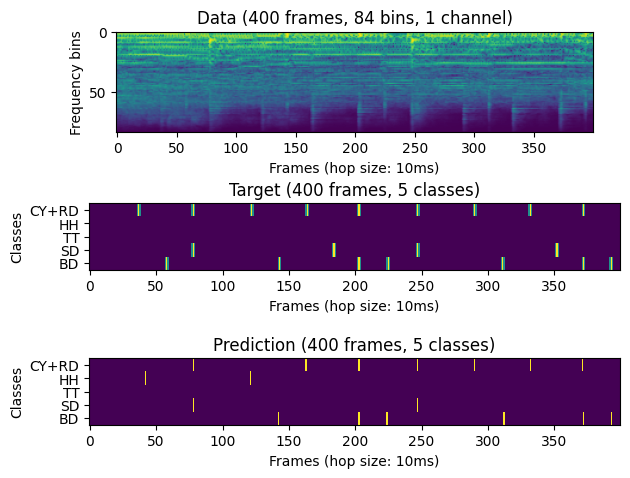

In [90]:
# Set the model to eval mode
model.eval()

# And plot a prediction
data, label = next(iter(val_loader))
plot_prediction(model, data, label)